https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

In [1]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Applying Transforms to the Data - normalization
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)), # 랜덤 크기로 자른 후 잘라낸 이미지의 크기는 256x256로 조정
        transforms.RandomRotation(degrees=15), # 영상을 -15~15도 범위에서 랜덤 각도로 회전
        transforms.RandomHorizontalFlip(), # 50% 확률로 이미지를 수평으로 랜덤하게 뒤집는다.
        transforms.CenterCrop(size=224), # 중앙에서 224x224 이미지를 자른다.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) # 3채널 tensor을 취하며 각 채널의 입력 평균과 표준 편차로 각 채널을 정규화
    ]),
    'valid': transforms.Compose([                   # 검증 및 테스트 데이터의 경우 resizedcrop과 rotalrotaion, horizontalfilp을 수행하지 않는다.
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}
print(image_transforms)

{'train': Compose(
    RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'valid': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'test': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Data

# Set train and valid directory paths

dataset = '/content/drive/MyDrive/data/caltech_10/'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257 bear, chimp...
print('num_class :', num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()} # class_to_idx 는 데이터 셋의 클래스 매핑 레이블을 반환
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
print(train_data_size, valid_data_size, test_data_size)

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

num_class : 10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}
600 100 409


In [6]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True) # pretrain 모델을 베이스로 하여 마지막 몇 층만을 바꿔 사용자 모델로 사용
resnet50 = resnet50.to(device)              # 최종 레이어만 우리의 클래스 수에 맞게 변경

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [7]:
# Freeze model parameters
for param in resnet50.parameters():   # 기본적으로 required_grad는 true로 설정되어 있다. 
    param.requires_grad = False       # 역전파에 의한 파라미터 값에 대한 모든 변경 사항이 저장하지 않는다. pretrain 모델은 이미 교육되어있기 때문에 false

In [8]:
# Change the final layer of ResNet50 Model for Transfer Learning , 마지막 fc layer을 수정하는 방법,
fc_inputs = resnet50.fc.in_features # fc = full connected layer, 마지막에 연결된 fc layer의 채널 수를 얻는다.

resnet50.fc = nn.Sequential(     
    nn.Linear(fc_inputs, 256),   # 마지막 완전히 연결된 계층에 대한 입력은 선형 계층, 255개의 출력값을 가짐
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs = 10 classes
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)


In [9]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [41]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    # batch size가 32라는 말은 각 batch마다 최대 32개의 이미지를 가질 수 있다는 것

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in tqdm(range(epochs)): # 고정된 epoch에 대해 각 이미지를 하나의 epoch에 한 번씩 처리
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad() # pytorch는 모든 gradient를 저장하기 때문에 zero_grad로 0을 만들어줘야 한다.
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) # 손실과 정확도 값을 얻기 위해 모든 batch에 평균을 낸다.
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
            # 과적합을 방지하기 위해 검증 셋을 유지하는 것이 중요하다.  
        
        # Validation - No gradient tracking needed
        with torch.no_grad(): # 검증 과정이다. gradient 계산이 필요하지 않기 때문에 no grad

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss > best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size        

        # Find average valid loss and valid accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start)) 

        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
        np_history = np.array(history)
        
        if epoch>=10 and np_history[epoch-1,2]<np_history[epoch,2] and np_history[epoch-1,0]>np_history[epoch,0]:break

    return model, history, best_epoch
    

In [42]:
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 30
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Epoch : 001, Training: Loss - 0.0568, Accuracy - 97.6667%, 
		Validation : Loss - 0.1816, Accuracy - 95.0000%, Time: 7.6559s
Epoch: 2/30
Epoch : 002, Training: Loss - 0.0446, Accuracy - 98.6667%, 
		Validation : Loss - 0.1800, Accuracy - 96.0000%, Time: 9.0368s
Epoch: 3/30
Epoch : 003, Training: Loss - 0.0617, Accuracy - 97.6667%, 
		Validation : Loss - 0.2264, Accuracy - 91.0000%, Time: 8.3921s
Epoch: 4/30
Epoch : 004, Training: Loss - 0.0228, Accuracy - 99.5000%, 
		Validation : Loss - 0.1946, Accuracy - 96.0000%, Time: 7.3702s
Epoch: 5/30
Epoch : 005, Training: Loss - 0.0217, Accuracy - 99.5000%, 
		Validation : Loss - 0.2170, Accuracy - 95.0000%, Time: 7.6008s
Epoch: 6/30
Epoch : 006, Training: Loss - 0.0681, Accuracy - 97.5000%, 
		Validation : Loss - 0.3338, Accuracy - 92.0000%, Time: 7.6202s
Epoch: 7/30
Epoch : 007, Training: Loss - 0.0640, Accuracy - 97.8333%, 
		Validation : Loss - 0.1667, Accuracy - 94.0000%, Time: 7.5946s
Epoch: 8/30
Epoch : 008, Training: Loss -

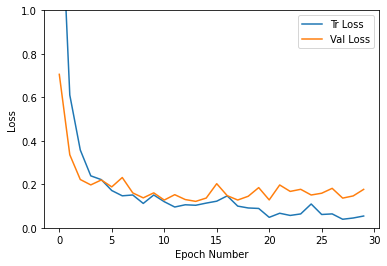

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

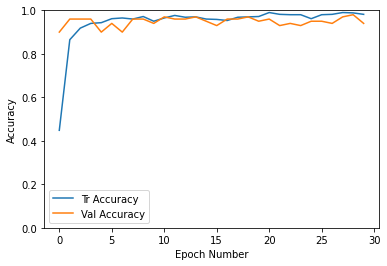

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
 def computeTestSetAccuracy(model, loss_criterion): # 개별 테스트 이미지 또는 전체 테스트 데이터 집합에 대해 추론을 수행하여 테스트 정확도를 얻는다. 검증 코드와 유사하다.
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [34]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test'] # 입력 이미지를 변환


    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image) 
    if torch.cuda.is_available(): # 4차원 텐서로 변환시켜 다른 클래스에 대한 로그 확률을 출력하는 모델
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1) # argmax와 비슷하게 top-k에 대한 결과 값을 받는다.
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])




In [ ]:
import wget

--2021-07-22 09:42:47--  https://cdn.pixabay.com/photo/2018/10/01/12/28/skunk-3716043_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324852 (317K) [image/jpeg]
Saving to: ‘skunk.jpg’

skunk.jpg           100%[===================>] 317.24K  --.-KB/s    in 0.03s   

2021-07-22 09:42:47 (11.6 MB/s) - ‘skunk.jpg’ saved [324852/324852]

Predcition 1 : skunk , Score:  0.999995
Predcition 2 : porcupine , Score:  4.987493e-06
Predcition 3 : bear , Score:  2.2303958e-08


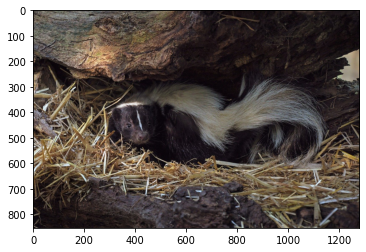

In [35]:
# Test a particular model on a test image
skunk = https://cdn.pixabay.com/photo/2018/10/01/12/28/skunk-3716043_1280.jpg -O skunk.jpg
dataset = 'caltech_10'
model = torch.load("{}_model_{}.pt".format(dataset, best_epoch))
predict(model, 'skunk.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)